## Forecasting with text mining

#### Task description:
***
The goal is to prepare a PoC which predicts the price of used iPhones 11. As the data is web-scraped from an online marketplace, it was created by random people providing different and unstructured information in natural language. It also contains plenty of noise, like non-iPhone offers or multiple items sold through one advertisement. 
There are also multiple different kinds of iPhone 11, which is not directly indicated in the dataset and thus requires analysis of the provided description for each offer.  

#### Task approach:
***
- Understanding and analysis of the original dataset
- Dataset cleaning
- Text mining to categorize offers into types of iPhones
- Exploration of the cleaned dataset
- Forecasting
- Evaluation

#### Data:
***
The data contains web-scraped information from an online marketplace OLX, more precisely offers in Polish created by users of this portal. Offers have details specified by their creators (mainly sellers), like offer titles, descriptions and state of items (condition).  
The prices are expressed in PLN (1 EUR = ~4.5 PLN).

In [149]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
warnings.resetwarnings()
# import spacy
# nlp = spacy.load('pl_core_news_sm')

In [150]:
# Notebook params

warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 15})

In [151]:
## Data reading
org_data = pd.read_csv('data.csv')
print('Dataset shape:', org_data.shape)
org_data.head(5)

Dataset shape: (5084, 13)


,http,voivodeship,scrap_time,name,price,brand,condition,offer_from,type,description,added_at,views,user_since
0,https://www.olx.pl/oferta/iphone-11-64-jak-now...,pomorskie,2021-02-22 06:55:30,Iphone 11 64 jak nowy 95% gwarancja wyświetlacz,2799.0,iPhone,Używane,Osoby prywatnej,Sprawny,Jak nowy . Kondycja baterii 95%. Kupiony w med...,2021-02-22 00:09:00,37,2013-05-01 00:00:00
1,https://www.olx.pl/oferta/skup-uszkodzonych-te...,pomorskie,2021-02-22 06:55:34,Skup uszkodzonych telefonów iPhone xs xs max 1...,NaN,NaN,NaN,Firmy,NaN,Witam. Kupię uszkodzone/ zablokowane/ zalane/...,2021-02-22 00:05:00,5242,2020-04-01 00:00:00
2,https://www.olx.pl/oferta/iphone-11-64-gb-czar...,pomorskie,2021-02-22 06:55:40,"IPhone 11 64 GB czarny, idealny z gwarancją. W...",2700.0,iPhone,Używane,Osoby prywatnej,Sprawny,Witam! Mam na sprzedaż iPhone’a 11 w wersji 64...,2021-02-21 19:00:00,186,2014-12-01 00:00:00
3,https://www.olx.pl/oferta/iphone-11-CID99-IDIk...,pomorskie,2021-02-22 06:55:44,Iphone 11,3000.0,iPhone,Nowe,Osoby prywatnej,Sprawny,Nowy 128GB Oryginalnie zapakowany kolor czar...,2021-02-21 18:24:00,250,2016-06-01 00:00:00
4,https://www.olx.pl/oferta/jak-nowy-apple-iphon...,pomorskie,2021-02-22 06:55:52,Jak Nowy Apple Iphone 11 256gbGB White Gwarancja,2899.0,iPhone,Używane,Firmy,Sprawny,Witaj. Jesteśmy sklepem - serwisem z 12 le...,2021-02-21 17:38:00,845,2012-08-01 00:00:00


### Dataset exploration

In [152]:
print(org_data.describe())
org_data[org_data['price']>10000]

              price          views
count   4747.000000    5084.000000
mean    2564.713467     763.351692
std      900.714124    2722.697621
min      100.000000       1.000000
25%     2399.000000      68.000000
50%     2689.000000     139.000000
75%     2950.000000     476.000000
max    12345.000000  121752.000000


,http,voivodeship,scrap_time,name,price,brand,condition,offer_from,type,description,added_at,views,user_since
609,https://www.olx.pl/oferta/etui-samsung-a31-a51...,dolnoslaskie,2021-01-08 00:02:17,"Etui samsung a31/a51 , iphone 11(pancer)",12345.0,NaN,Nowe,Osoby prywatnej,NaN,Etui Samsung-15 zł iPhone -30 zł Nówki sztu...,2021-01-07 12:35:00,78,2020-11-01 00:00:00


There are some small values present in the data set (price < 1000), but also some very big ones (>10.000). The standard price range of a few years old iPhones is over 1000 PLN, but less than 6000, thus values outside of this range do not make much sense. 

Review of these records showed that these are accessories (eg phone case), different phones or bulk offers. They will be filtered out as the focus is on iPhones 11 only.

In [153]:
print('First available observation:', org_data.added_at.min())
print('Last available observation:',org_data.added_at.max())
# Very short time period of available data

First available observation: 2021-01-01 00:15:00
Last available observation: 2021-02-25 10:31:00


In [154]:
# Missing values
print('Unique rows with nulls:', org_data[org_data.isnull().any(axis=1)].count()[0])
org_data.isna().sum()

Unique rows with nulls: 677


http             0
voivodeship      0
scrap_time       0
name             0
price          337
brand          466
condition      131
offer_from       0
type           458
description      0
added_at         0
views            0
user_since       0
dtype: int64

There are missing values in the dataset in price, brand, condition and type columns. While there are around 1400 missing values, they appear in less than 700 rows. This means that often there is more than one missing value per observation. 

This often happens with offers with accessories or with bulk ads, where they buy/sell multiple phones/items. Such offers need to be filtered out. Relevant information could be extracted from individual descriptions 

In [155]:
# Checking unique values of key columns
print('Brand types:', org_data.brand.unique())
print('Condition types:', org_data.condition.unique())
print(org_data.type.unique())

Brand types: ['iPhone' nan 'Inne telefony gsm' 'Samsung' 'LG']
Condition types: ['Używane' nan 'Nowe']
['Sprawny' nan 'Uszkodzony' 'Męskie']


Apart from used iPhones, the dataset contains new phones and also from other manufacturers.

For this task we are interested in just used iPhones.

In [156]:
data = org_data[org_data.brand == 'iPhone']
data = data[data.condition == 'Używane']
data = data[data.type == 'Sprawny']
data = data[~data.price.isna()]

data['date'] = data['added_at'].str[:10]
data = data.drop(columns='added_at')
data = data[['name', 'price', 'brand', 'condition', 'type', 'description', 'date']].copy()

print(data.describe())

             price
count  2754.000000
mean   2635.539887
std     612.208260
min     200.000000
25%    2350.000000
50%    2550.000000
75%    2900.000000
max    6000.000000


Out of 5k records over 2k were not relevant. The dataset is not clean yet, as there are still other iPhones present (like 5s with the price of 200).

### Flagging models of phones

In [157]:
# Exemplary review of name and description fields - they have 
# the relevant information: model type, storage etc 
for field in ['name', 'description']:
    for obs in data[field][:2]:
        print(obs, '\n')

Iphone 11 64 jak nowy 95% gwarancja wyświetlacz 

IPhone 11 64 GB czarny, idealny z gwarancją. Wymiana 

Jak nowy . Kondycja baterii 95%. Kupiony w media markt . Posiadam faktury . Dodatkowa gwarancja na zbity wyświetlacz wartość 600zł . Dodatkowo szkło hartowane 5D oraz pokrowiec SPIGEN wartość 80zl. Nie sprzedaje za granice !! . Polecam 

Witam! Mam na sprzedaż iPhone’a 11 w wersji 64 GB. Telefon jest w stanie idealnym, wręcz jak nowym, ani jednej rysy ma przedzie l, rantach czy tyle. Posiada gwarancje do 17 września 2021 roku. Zakupiony w sieci play przez pierwszego właściciela, odkupiłem telefon jako nowy i wykonałem skany dokumentów osobiście. Zdjęć telefonu nie zamieściłem z powodu braku drugiego telefonu, jednakże wyglada on jak nowy. Założone jest szkło hartowane, lekko pęknięte chyba od kluczy w kieszeni natomiast ubrany jest w siwe etui Apple. Umieszczam screen gwarancji. Wszystkie dokumenty z pudełka i słuchawki nowe, nigdy nie wyjmowane. Bateria kondycja 100% 



For many NLP tasks a good approach would be to use pretrained models. One of the popular and well-working libraries is spacy, which offers a ready to use polish model(pl_core_news_sm). This is especially handy for semantic analysis, but also for any tasks that require natural language processing by computers.

But in the specific case the task can be done simpler. There are just a few types of iPhones and using a sophisticated model is not necessarily required, as the results can be similar to text mining approach. This is especially true for a PoC, when we want to validate first if something works at all.  

There are usually a few types of one iPhone model. In the case of iPhone 11, these are: standard model (11), 11 Pro and 11 Pro Max, with storages being one of [64, 128, 256, 512]. As this information is crucial when purchasing such phone, these names must be specified in the title/description of each offer.

In [158]:
## Function to check presence of tags (crucial model information) 
def check_presence(df, text):
    ''' 
    Checking presence of a specified 'text' (model/storage) in columns 'name' 
    and 'description' of indicated pandas dataframe containing scrapped 
    data of iPhone 11 offers.

    Output:
    -------
    Pandas df with a binary column named after 'text'.
    If 'text' is present, returns 1. Otherwise returns 0.
    '''

    df['name'] = df['name'].str.lower()
    df['description'] = df['description'].str.lower()
    
    col1_check = df['name'].str.contains(text)
    col2_check = df['description'].str.contains(text)
    return col1_check.astype(int) | col2_check.astype(int)

## Checking tags presence
params = ['11', '64', '128', '256', '512', '64gb', '128gb', '256gb', '512gb', 'pro ', 'pro max']
for text in params:
    data[text] = check_presence(data, text)

# words like "Professional" were counted as "Pro". Space was added to eliminate this problem
data['pro'] = data['pro '] 
data['pro_max'] = data['pro max']
data.drop(columns=['pro ', 'pro max'], inplace=True)

## Because all Pro Maxes also contain "Pro" and thus received flag "Pro" as 1, 
## changing all these instances to 0
data.loc[data['pro_max'] == 1, 'pro'] = 0

# Merging storages which are the same
def merging_flags(df):
    ''' Merging flags which mean the same, eg "64" and "64GB "'''

    df['64'] = df['64'] | df['64gb']
    df['128'] = df['128'] | df['128gb']
    df['256'] = df['256'] | df['256gb']
    df['512'] = df['512'] | df['512gb']
    df.drop(columns=['64gb', '128gb', '256gb', '512gb'], inplace=True)

merging_flags(data)

In [159]:
# Df with the new columns
data.head(3)

,name,price,brand,condition,type,description,date,11,64,128,256,512,pro,pro_max
0,iphone 11 64 jak nowy 95% gwarancja wyświetlacz,2799.0,iPhone,Używane,Sprawny,jak nowy . kondycja baterii 95%. kupiony w med...,2021-02-22,1,1,0,0,0,0,0
2,"iphone 11 64 gb czarny, idealny z gwarancją. w...",2700.0,iPhone,Używane,Sprawny,witam! mam na sprzedaż iphone’a 11 w wersji 64...,2021-02-21,1,1,0,0,0,0,0
4,jak nowy apple iphone 11 256gbgb white gwarancja,2899.0,iPhone,Używane,Sprawny,witaj. jesteśmy sklepem - serwisem z 12 le...,2021-02-21,1,0,0,1,0,0,0


In [160]:
# Checking if all rows have storage information
no_storage = data[data['64']==0][data['128']==0][data['256']==0]
print(no_storage.count()[0])
# print(no_storage.head(2))

mask = (data['64'] == 0) & (data['128'] == 0) & (data['256'] == 0)
data = data[~mask]

260


<ipython-input-160-ac4b2a70d00f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_storage = data[data['64']==0][data['128']==0][data['256']==0]


There are 260 cases where the storage is not specified at all in description. These might be the base models, but not necessarily. If needed, these observations could be treated as base version and added to training, then checked if their presence helps the model.
For now these observations are filtered out.

There is also an example of an observation which is not iPhone 11, but iPhone 7, with 11 free cases. Such noise in NLP is usually hard to fully eliminate.

The next step is to create labels - to flag phones as specific models

In [161]:
### Creating labels
models = ['pro_max', 'pro']
storages = ['64', '128', '256', '512']

def labels_function(df):
    ''' 
    Assigning labels as phone types. Examples: 11_64, Pro_Max_256
    By iterating through rows, a flag is created if the row is a Pro model.
    If Pro was not detected, assigned flag is the base iPhone 11 model with its storage.

    If storage was not specified, no flag is given to such offer.
    '''

    for index, row in df.iterrows():    
        row_flag = 0
        for model in models:
            if row[model] == 1 and row_flag == 0:
                row_flag = 1 #local flag to skip flagging the offer as base model 
                for storage in storages:
                    if row[storage] == 1:
                        df.at[index, model+'_'+storage] = 1
        if row_flag == 0: 
            for storage in storages:
                if row[storage] == 1:
                    df.at[index, '11_'+storage] = 1

def melting_function(df):
    ''' Assigning labels as phone types through calling the labels_function
    and melting the different labels to one column '''
    
    labels_function(df)
    df = df.reset_index()
    melting = pd.melt(df, 
                      id_vars = ['index','name', 'price', 'brand', 'condition', 'type', 
                      'description', 'date'], 
                      value_vars=['11_64', '11_256', '11_128', 'pro_64', 'pro_128', 
                      'pro_256', 'pro_512', 'pro_max_128', 'pro_max_256', 'pro_512'])
    return melting[melting['value']==1]

data_lab = melting_function(data)
data_lab.head(2)

,index,name,price,brand,condition,type,description,date,variable,value
0,0,iphone 11 64 jak nowy 95% gwarancja wyświetlacz,2799.0,iPhone,Używane,Sprawny,jak nowy . kondycja baterii 95%. kupiony w med...,2021-02-22,11_64,1.0
1,2,"iphone 11 64 gb czarny, idealny z gwarancją. w...",2700.0,iPhone,Używane,Sprawny,witam! mam na sprzedaż iphone’a 11 w wersji 64...,2021-02-21,11_64,1.0


In [162]:
# Number of observations returning multiple flags
lab_count = data_lab[data_lab['value']==1].groupby('index').count()
print(lab_count[lab_count['value']>1]['name'].count())

# Removing offers with multiple flags - these are eg bulk offers
mask = lab_count['value']>1
multiple = [x for x in mask.loc[mask == True].index]
filtered_data = data_lab[~data_lab['index'].isin(multiple)]

# Clearing indexes
filtered_data = filtered_data.reset_index()
filtered_data = filtered_data.drop(columns=['index', 'level_0', 'value'])
filtered_data = filtered_data.rename(columns = {'variable': 'label'})

print(filtered_data.shape)

53
(2267, 8)


### Clean data visualization

[Text(0, 0, '1368'),
 Text(0, 0, '480'),
 Text(0, 0, '206'),
 Text(0, 0, '133'),
 Text(0, 0, '90'),
 Text(0, 0, '85'),
 Text(0, 0, '7'),
 Text(0, 0, '3'),
 Text(0, 0, '2')]

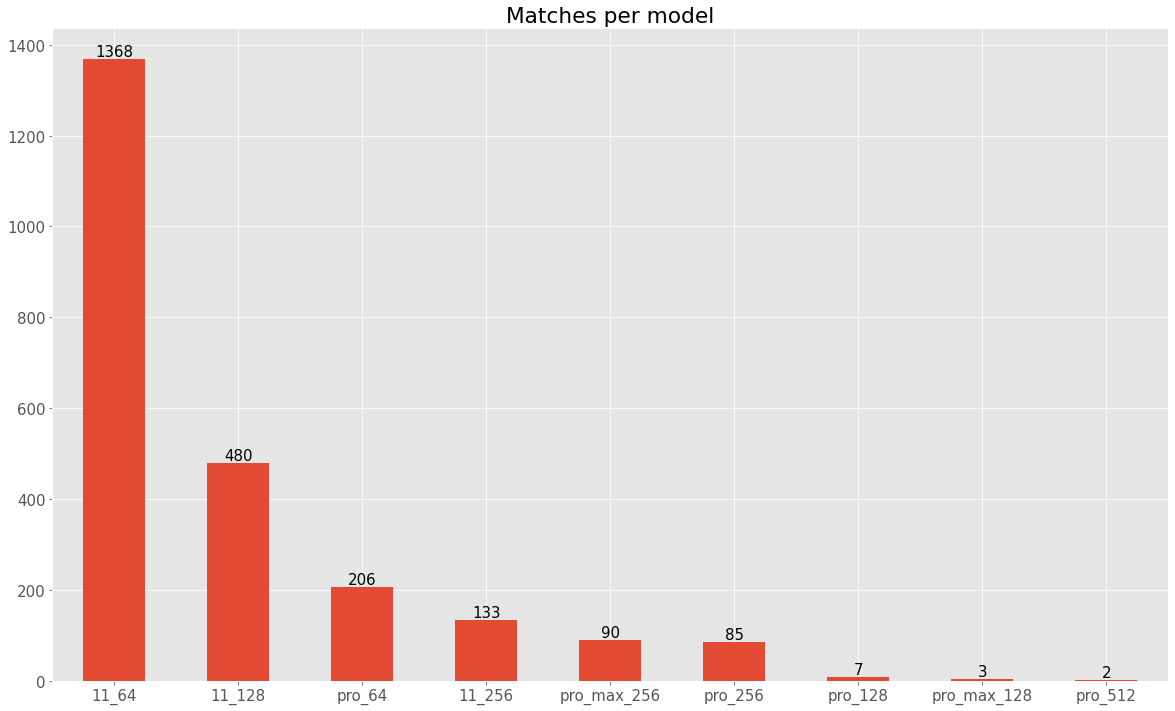

In [174]:
# Number of matches per phone model
ax = data_lab['variable'].value_counts().plot(kind = 'bar', rot=0)
plt.title('Matches per model')
ax.bar_label(ax.containers[0])

<ipython-input-173-588e577b4047>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_price = filtered_data.groupby(['date', 'label']).mean()


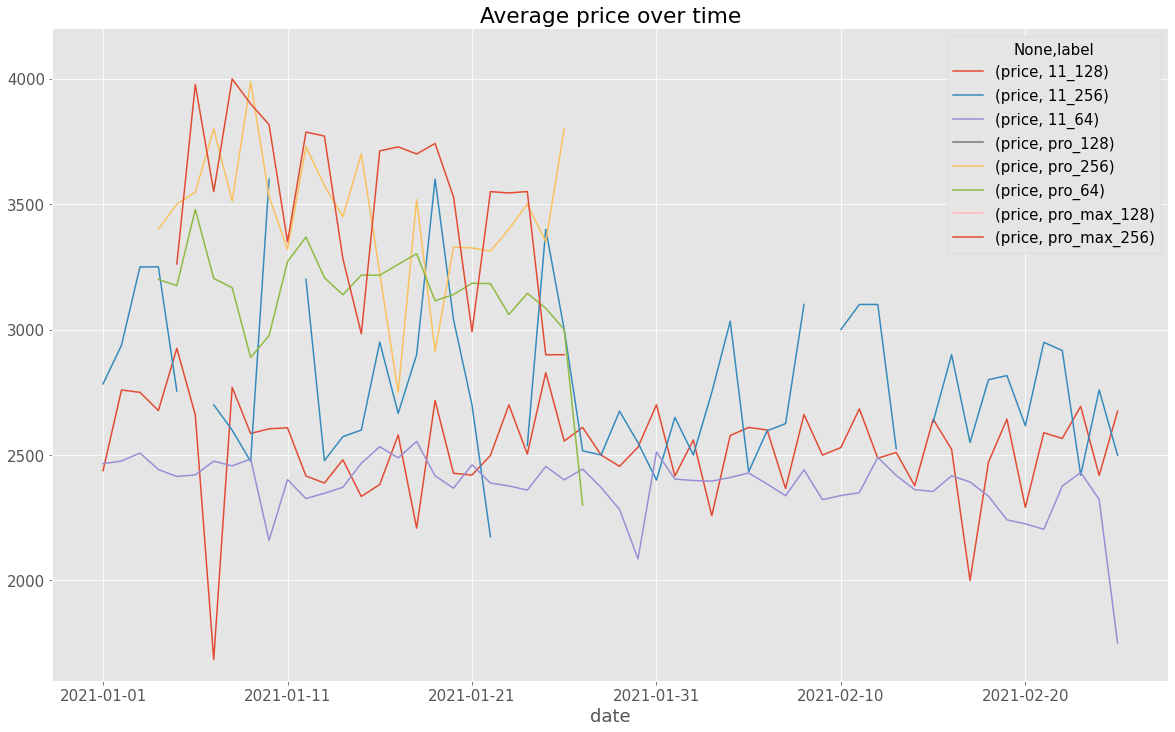

<ipython-input-173-588e577b4047>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_price = filtered_data.groupby(['date', 'label']).median()


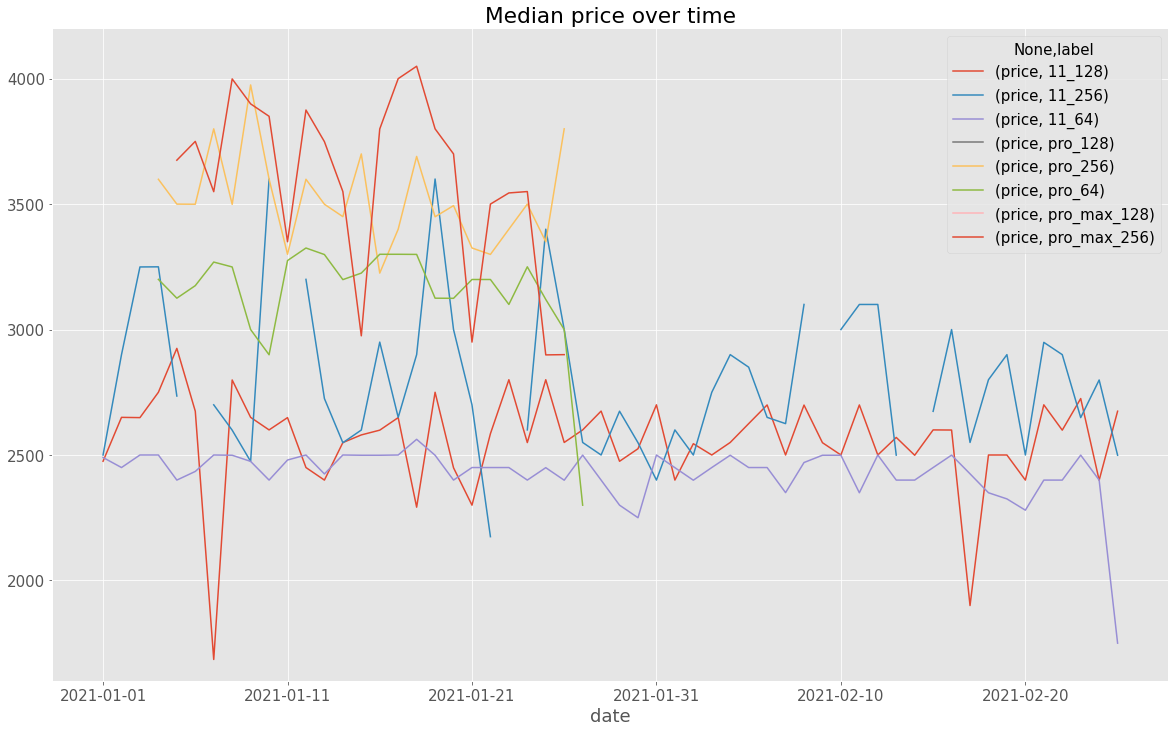

In [173]:
# Visualizing models history of average and median prices
plt.rcParams["figure.figsize"] = (20,12)

# Mean
avg_price = filtered_data.groupby(['date', 'label']).mean()
ax = avg_price.unstack().plot()
ax.set_ylim(1600, 4200)
plt.title('Average price over time')
plt.show()

# Median
median_price = filtered_data.groupby(['date', 'label']).median()
ax = median_price.unstack().plot()
ax.set_ylim(1600, 4200)
plt.title('Median price over time')
plt.show()

- The mostly matched type is the standard iPhone 11 64 GB with over 1300 matches. The other models are left behind, with the second-best model (11 128GB) having less than 500 matches
- The number of observations affects the price stability. This can be seen by comparing various phone models. While the variation is not high for 11 64 GB model, for the second most popular one the prices randomly spike. The prices of other models are even more unstable
- Period of available data is very short (1.5 month). It makes it impossible to check yearly seasonality, but there might exist some hidden weekly or monthly ones 
- For this PoC the focus is on the base model, as the most data is available for it  

### Forecasting

In [165]:
# As described above, for the purpose of this PoC the focus is on the base 
# iPhone 11 64 GB model

basic = filtered_data[filtered_data['label']=='11_64'].groupby(['date', 'label']).mean()
basic = basic.reset_index().drop('label', axis = 1)
basic = basic.set_index('date')
basic = basic
basic.head(3)

<ipython-input-165-f6de70b718d6>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  basic = filtered_data[filtered_data['label']=='11_64'].groupby(['date', 'label']).mean()


,price
date,
2021-01-01,2465.619048
2021-01-02,2476.000000
2021-01-03,2507.940000


Just two months of daily data makes it difficult to accurately identify and model the trend and seasonality components, as there may not be enough information to reliably estimate these components. For this reason the decomposition step is skipped.

However, there still might be present weekly/monthly seasonality. For this reason the SARIMA model is tested. 

ADF Statistic: -3.4062549425739825
p-value: 0.010747480235056402
Critical Values:
	1%: -3.5552728880540942
	5%: -2.9157312396694217
	10%: -2.5956695041322315
None


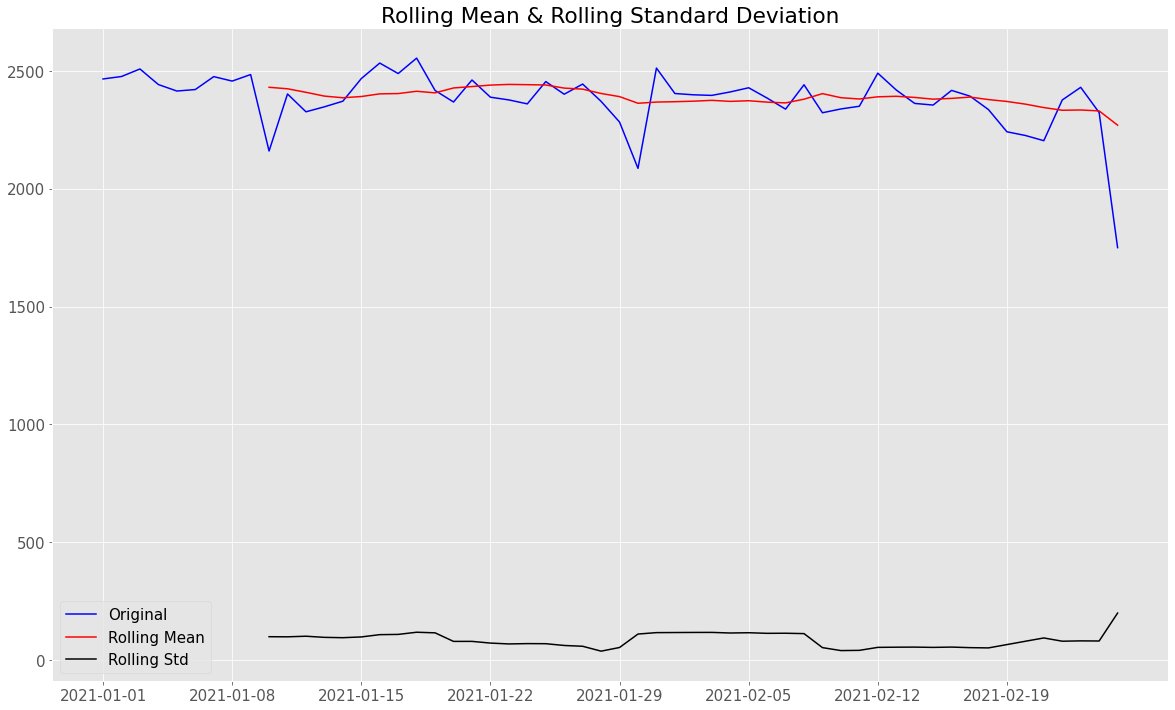

In [166]:
### Checking if data is stationary

rolling_mean = basic.rolling(window = 10).mean()
rolling_std = basic.rolling(window = 10).std()

# Running Dickey Fuller test
def dickey_fuller_test(df):
    result = adfuller(df['price'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

print(dickey_fuller_test(basic))


# Ticks adjustment
ticks_all = basic.index.tolist()
ticks = ticks_all[0::7]

fig, ax = plt.subplots()
plt.plot(basic, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
ax.set_xticks(ticks)
plt.show()

Dickey Fuller test confirms the data is stationary considering threshold of 0.05.

The next step is finding the optimal parameters for SARIMA.

In [167]:
warnings.filterwarnings("ignore")

model_data = basic
model_data.index = pd.DatetimeIndex(model_data.index)

## Finding parameters for time series model
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
AIC_estimates = []
params1 = []
params2 = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(model_data['price'],order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit()
            # print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            params1.append(param)
            params2.append(param_seasonal)
            AIC_estimates.append(results.aic)
        except: 
            continue

print('Tested {} possibilities'.format(len(AIC_estimates)))
print('The lowest estimate for AIC is ', min(AIC_estimates))
print('Parameters with the lowest AIC {} {}'.format(
    params1[AIC_estimates.index(min(AIC_estimates))], 
    params2[AIC_estimates.index(min(AIC_estimates))]))
warnings.resetwarnings()

Tested 63 possibilities
The lowest estimate for AIC is  558.9537410773144
Parameters with the lowest AIC (1, 1, 1) (1, 1, 0, 12)


In [168]:
## Training the SARIMA model
## Model is trained on 41 days (75%), thus 14 (25%) are left for performance testing 
warnings.filterwarnings("ignore")
mod = sm.tsa.statespace.SARIMAX(model_data['price'][:41],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
warnings.resetwarnings()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2278      0.133      1.715      0.086      -0.033       0.488
ma.L1         -1.0000      0.264     -3.787      0.000      -1.518      -0.482
ar.S.L12      -0.4801      0.200     -2.398      0.016      -0.873      -0.088
sigma2      1.154e+04   2.29e-05   5.04e+08      0.000    1.15e+04    1.15e+04


### Evaluation

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Text(0.5, 1.0, 'Prediction and real values comparison')

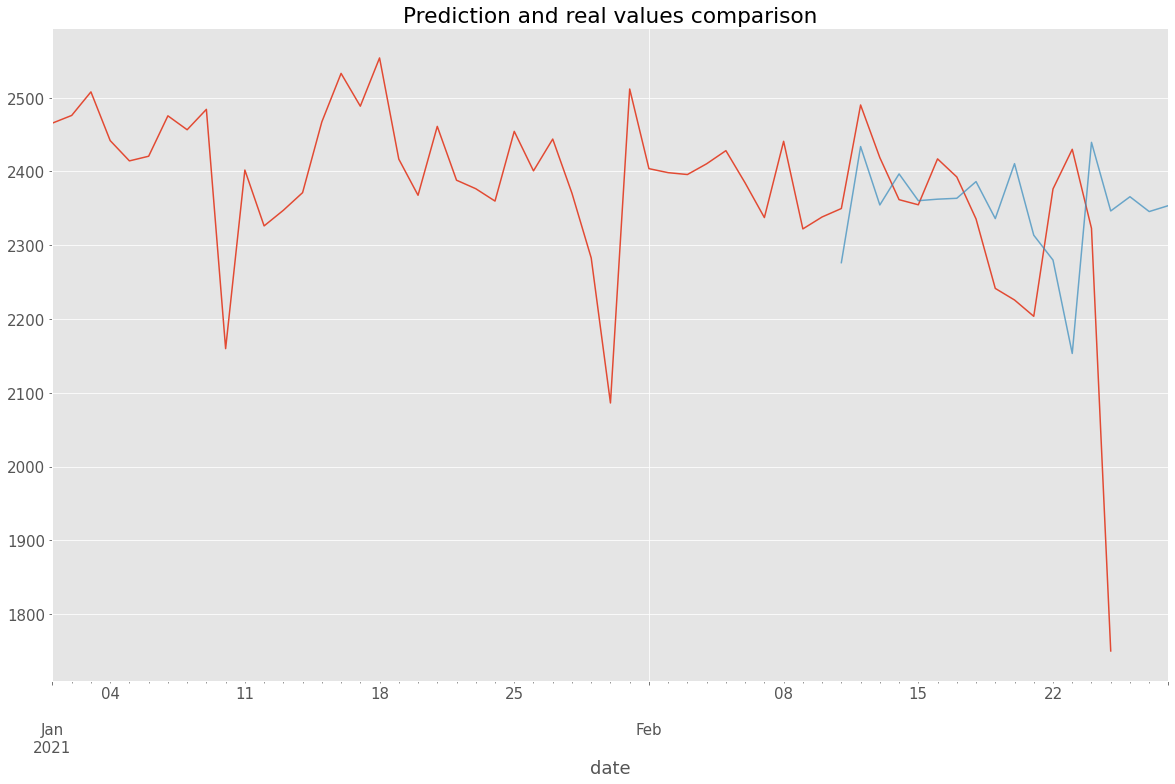

In [169]:
## Getting predictions and comparing them to the real data
pred = results.get_prediction(start=pd.to_datetime('2021-02-11'), 
                                end=pd.to_datetime('2021-02-28'))

ax = model_data['price'].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
plt.title('Prediction and real values comparison')

In [170]:
## Evaluation scores
df_forecasted = pred.predicted_mean
df_truth = model_data['price']
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error: {}'.format(round(mse, 2)))
print('The Root Mean Squared Error: {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error: 35391.33
The Root Mean Squared Error: 188.13


The RMSE is 188, which means the average prediction differs by ~188 PLN from the real price, which considering average price around 2400 PLN is a good result. However, the test size is small - despite being 25% of the population.

However, the model can be further improved. The ideas are described at the end of the notebook. 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


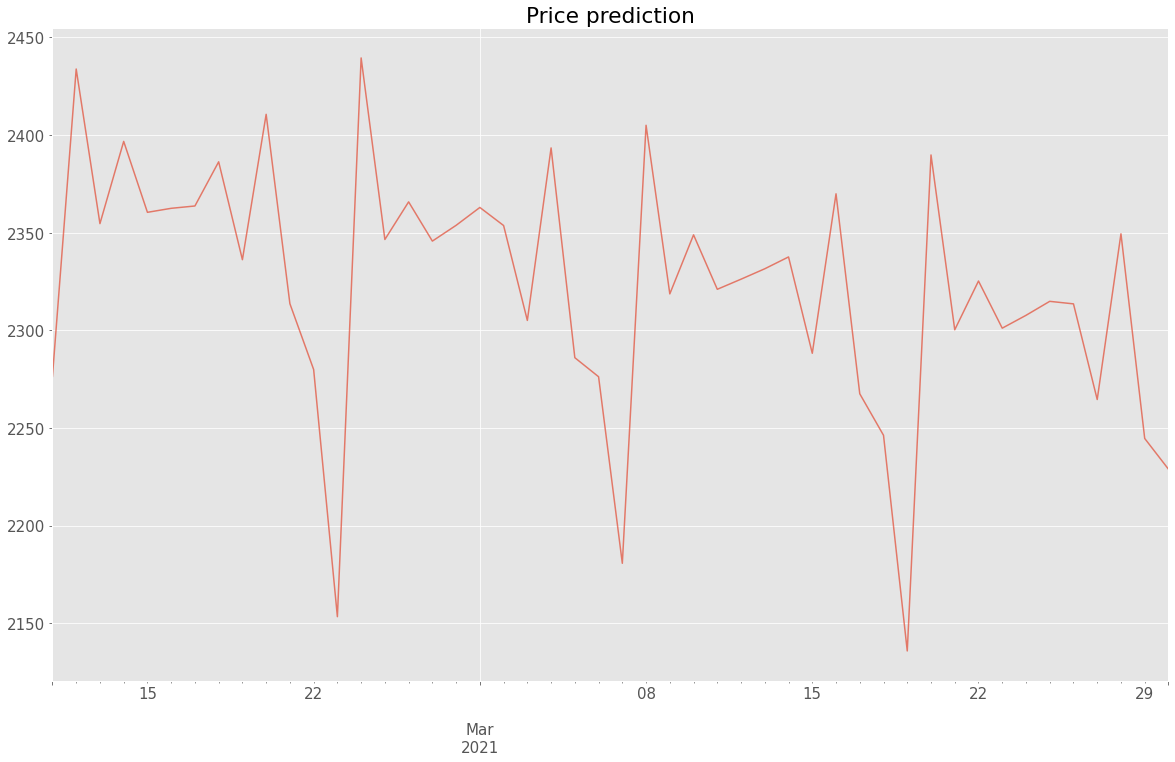

In [171]:
## Getting prediction for a month in advance

pred = results.get_prediction(start=pd.to_datetime('2021-02-11'), 
                                end=pd.to_datetime('2021-03-30'))
pred.predicted_mean.plot(label='Forecast', alpha=.7)
plt.title('Price prediction')
plt.show()

In [172]:
## Predicted prices of iPhone 11 64 GB
pred.predicted_mean[18:]

2021-03-01    2362.920362
2021-03-02    2353.663090
2021-03-03    2305.053704
2021-03-04    2393.413152
2021-03-05    2285.964283
2021-03-06    2276.209227
2021-03-07    2180.647010
2021-03-08    2405.017089
2021-03-09    2318.644890
2021-03-10    2348.887694
2021-03-11    2321.000159
2021-03-12    2326.182532
2021-03-13    2331.517751
2021-03-14    2337.572112
2021-03-15    2288.225413
2021-03-16    2369.913105
2021-03-17    2267.480113
2021-03-18    2246.223259
2021-03-19    2135.754485
2021-03-20    2389.813767
2021-03-21    2300.258744
2021-03-22    2325.235750
2021-03-23    2301.089578
2021-03-24    2307.660229
2021-03-25    2314.831527
2021-03-26    2313.534082
2021-03-27    2264.541400
2021-03-28    2349.432504
2021-03-29    2244.591163
2021-03-30    2228.856841
Freq: D, Name: predicted_mean, dtype: float64

### Improvements ideas
Next steps to improve this PoC could be:
- Getting more data. While the provided dataset proved to be enough, the more data is available, the better results can be achieved
- Text mining improvement/other NLP approaches. While the described approachs works, still some observations might be falsely classified or pass through the filters. NLP might provide better results, but it will include more steps and require more computing power. 
- Other time series models might be tested. While SARIMA seems to be handling the situation, the seasonal component is not certain. A good idea would be to test ARIMA and other approaches   

